### Setup

In [1]:
import numpy as np
import glob, os
from tqdm.auto import tqdm

In [2]:
# Setting up the cache
import os
caches_dir = ["F:/.cache/", "D:/cache/"]

# Will set the cache in the first caches dir found in the storage
for cache in caches_dir:
    if os.path.exists(cache):
        os.environ['HF_HOME'] = cache
        print(f"Cache path set on {cache}")
        break
    else:
        print(f"Path does not  exist {cache}")

Cache path set on F:/.cache/


In [3]:
path = r"TREES_2.tar"
if not os.path.exists(path):
    print(f"Path does not  exist {path}")

In [4]:
import datasets
datasets.enable_progress_bars

# load a custom dataset from local/remote files or folders using the ImageFolder feature
dataset = datasets.load_dataset("imagefolder", data_files=path, split="train").cast_column("image", datasets.Image(decode=False))
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 959
})

In [5]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

label2id

{'Iinstia bijuga': 0,
 'Mangifera indica': 1,
 'Pterocarpus indicus': 2,
 'Roystonea regia': 3,
 'Tabebuia': 4}

### Testing

In [6]:
# Taking the core functions of the model for classification
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = r'resnet-50-finetuned-FBark'

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [7]:
from transformers import pipeline

pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=image_processor)

In [8]:
# Creating the confusion matrix
from PIL import Image

true_labels = [id2label[i] for i in dataset['label']]

predicted_labels = []
misclassified_images_path = []
misclassified_labels = []

In [9]:
for i, item in tqdm(enumerate(dataset['image'])):
    image = Image.open(item['path'])
    result = pipe(image)
    predicted_label = max(result, key=lambda x: x['score'])['label']
    predicted_labels.append(predicted_label)
    
    # Check if the prediction is correct
    if predicted_label != true_labels[i]:
        misclassified_images_path.append(item['path'])
        misclassified_labels.append((predicted_label, true_labels[i])) # Tuples 

0it [00:00, ?it/s]

### Data Visualization

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

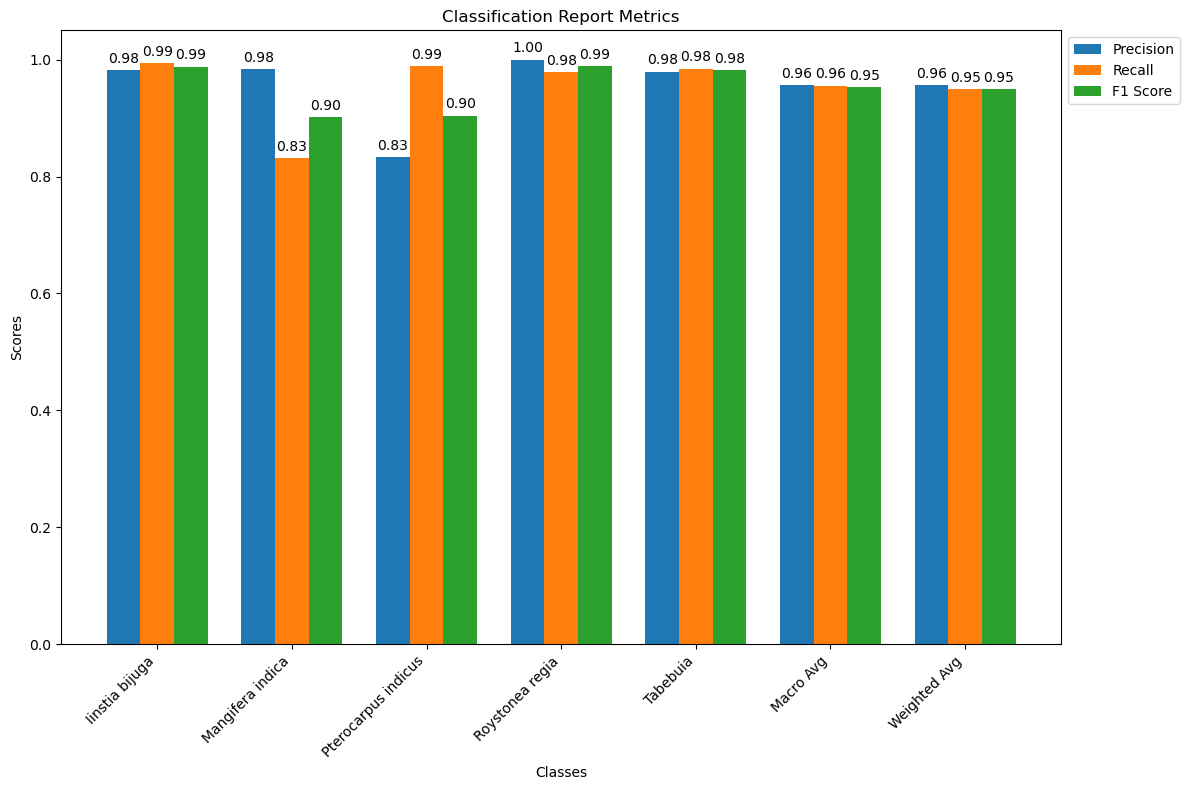

Overall Accuracy: 0.95


In [16]:

# Generate classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Extract class-wise metrics
precision = report_df['precision'][:-3]
recall = report_df['recall'][:-3]
f1_score = report_df['f1-score'][:-3]

# Extract overall metrics
accuracy = report_df.loc['accuracy']['f1-score']
macro_avg = report_df.loc['macro avg'][['precision', 'recall', 'f1-score']]
weighted_avg = report_df.loc['weighted avg'][['precision', 'recall', 'f1-score']]

# Plotting
labels = precision.index.tolist() + ['Macro Avg', 'Weighted Avg']
precision = precision.tolist() + [macro_avg['precision'], weighted_avg['precision']]
recall = recall.tolist() + [macro_avg['recall'], weighted_avg['recall']]
f1_score = f1_score.tolist() + [macro_avg['f1-score'], weighted_avg['f1-score']]

x = np.arange(len(labels))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Create bars
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

# Place legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Function to add labels to bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Attach labels to bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig('Classification Report Metrics.png', dpi=300)  # Increase dpi for higher quality
plt.show()

# Print overall accuracy separately
print(f"Overall Accuracy: {accuracy:.2f}")

In [17]:
report

{'Iinstia bijuga': {'precision': 0.9819277108433735,
  'recall': 0.9939024390243902,
  'f1-score': 0.9878787878787879,
  'support': 164.0},
 'Mangifera indica': {'precision': 0.9842931937172775,
  'recall': 0.831858407079646,
  'f1-score': 0.9016786570743405,
  'support': 226.0},
 'Pterocarpus indicus': {'precision': 0.8325991189427313,
  'recall': 0.9895287958115183,
  'f1-score': 0.9043062200956937,
  'support': 191.0},
 'Roystonea regia': {'precision': 1.0,
  'recall': 0.9782608695652174,
  'f1-score': 0.989010989010989,
  'support': 184.0},
 'Tabebuia': {'precision': 0.9794871794871794,
  'recall': 0.9845360824742269,
  'f1-score': 0.9820051413881749,
  'support': 194.0},
 'accuracy': 0.9499478623566214,
 'macro avg': {'precision': 0.9556614405981124,
  'recall': 0.9556173187909998,
  'f1-score': 0.9529759590895972,
  'support': 959.0},
 'weighted avg': {'precision': 0.9557177798717336,
  'recall': 0.9499478623566214,
  'f1-score': 0.9499489104864729,
  'support': 959.0}}

In [18]:
labels = dataset.features["label"].names
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
cm

array([[163,   0,   1,   0,   0],
       [  1, 188,  34,   0,   3],
       [  0,   1, 189,   0,   1],
       [  2,   1,   1, 180,   0],
       [  0,   1,   2,   0, 191]], dtype=int64)

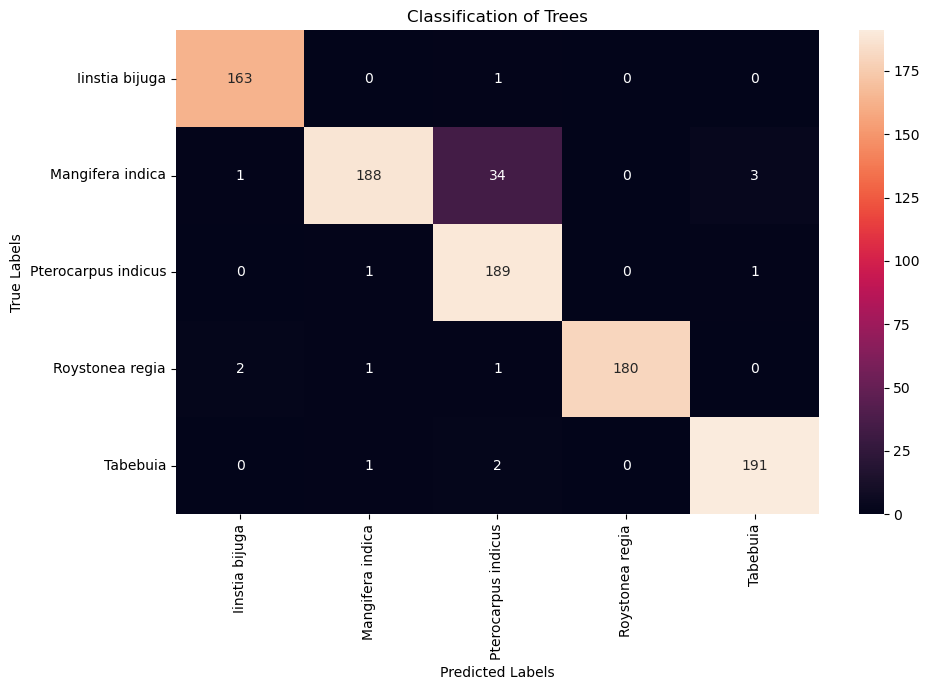

In [19]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Classification of Trees')
plt.tight_layout()
plt.savefig('heatmap_train_35E.png', dpi=300)  # Increase dpi for higher quality
plt.show()

### Misclassified Images

In [20]:
from collections import defaultdict

# Group the misclassified Images
misclassified_by_class = defaultdict(list)

for path, (pred_label, true_label) in zip(misclassified_images_path, misclassified_labels):
    misclassified_by_class[true_label].append((path, pred_label))

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

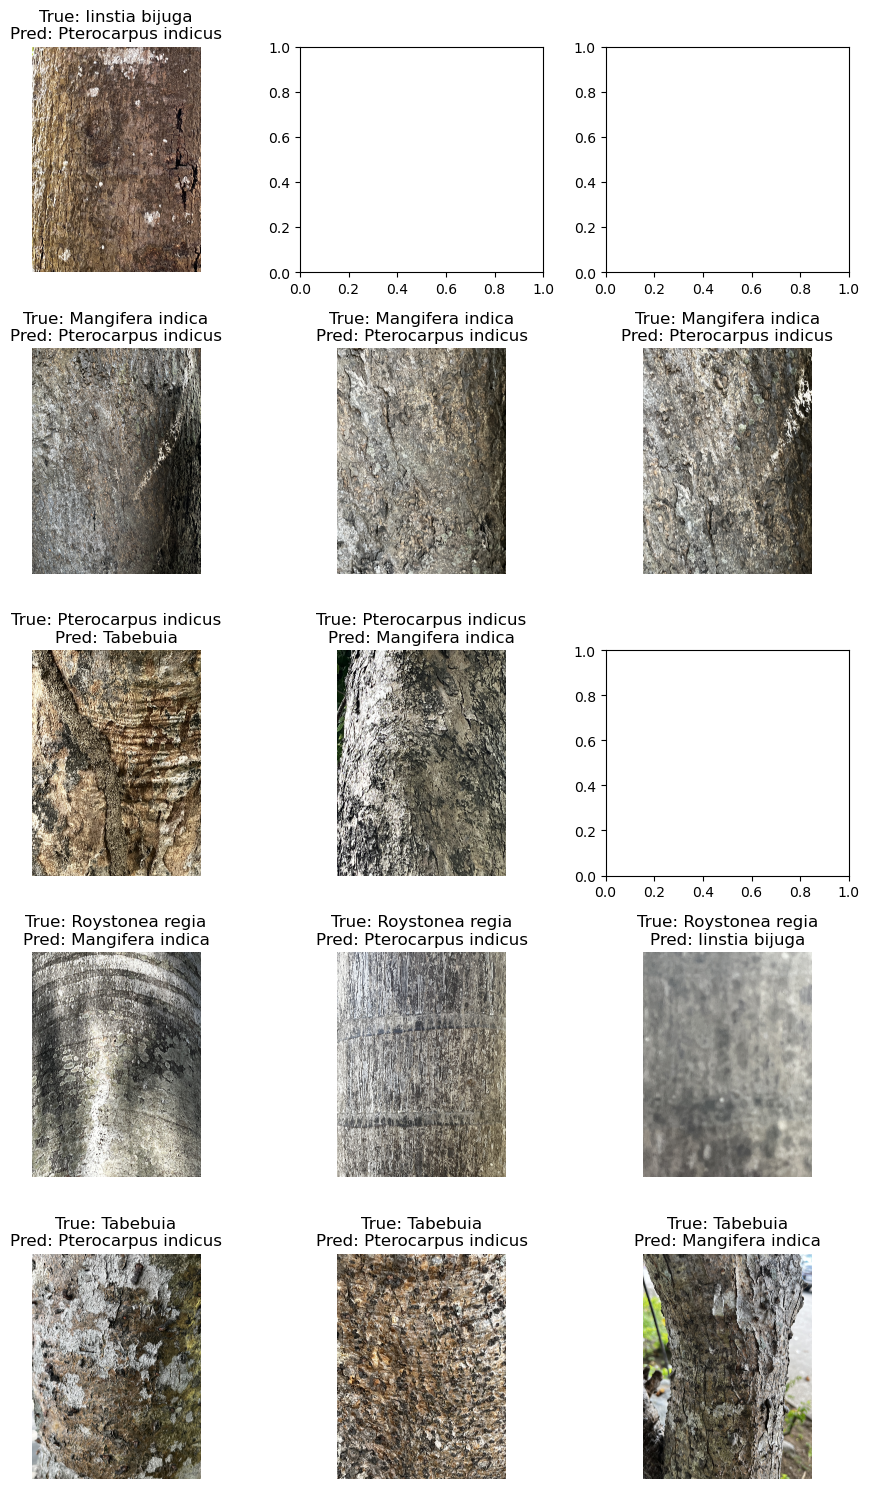

In [21]:
# Display misclassified images
def display_misclassified_images(misclassified_by_class, images_per_class=3):
    classes = list(misclassified_by_class.keys())
    num_classes = len(classes)
    
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(images_per_class * 3, num_classes * 3))
    
    for i, cls in tqdm(enumerate(classes)):
        misclassified_images = misclassified_by_class[cls]
        for j in tqdm(range(min(images_per_class, len(misclassified_images)))):
            img_path, pred_label = misclassified_images[j]
            image = Image.open(img_path)
            ax = axes[i, j] if num_classes > 1 else axes[j]
            ax.imshow(image)
            ax.set_title(f"True: {cls}\nPred: {pred_label}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('Misclassification.png', dpi=300)  # Increase dpi for higher quality
    plt.show()

# Display misclassified images
display_misclassified_images(misclassified_by_class)

(-0.5, 3023.5, 4031.5, -0.5)

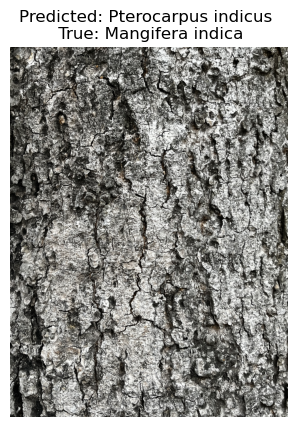

In [22]:
img_path = misclassified_images_path[9]
rlabels = misclassified_labels[9]
image = Image.open(img_path)
pred_label, true_label = rlabels
plt.imshow(image)
plt.title(f"Predicted: {pred_label} \n True: {true_label}")
plt.axis('off')